In [6]:
# Clustering at country level
# David Lopez
# Using country-level data + GDP + Health % + Pop Size & Density + Country Size & Location
# Notes: It would be better to get as in-depth as possible (state/subregion), however for this case I'll just do countries

In [177]:
# Modules
import pandas as pd
import matplotlib.pyplot as mplot
import numpy as np
from datetime import datetime
import seaborn as sbn
#from sklearn import preprocessing
from sklearn.decomposition import KernelPCA
#TODO: get skfuzzy
#import skfuzzy as fuz
#from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [8]:
# Global Vars
source_path='C:/Users/dalop/Documents/dat/covid_forecast'

In [104]:
# Loading Country Level Train Data (train.csv), with Date, Week of Year vars, Country string cleaning
df_train= pd.read_csv('{}/train_country_level.csv'.format(source_path))
df_train['Date']= pd.to_datetime(df_train['Date'],infer_datetime_format=True)
df_train['Woy']= df_train['Date'].dt.week
#pd.Series(['\(\)\',\*']).str.replace(df_train['Country_Region']
# Cleaning Country_Region: Remove special charachters, US -> United States
df_train_clean= df_train.drop(0)
#display(df_train_clean)
df_train_clean['Country_Region']= df_train['Country_Region'].str.replace('[\(\)\',\*-]',' ').str.replace(' +',' ').str.replace('^ +| +$','').str.replace('US','United States')
#display(df_train_clean[df_train_clean['Country_Region']=='United States'])
df_train_clean['ConfirmedCases']= pd.to_numeric(df_train_clean['ConfirmedCases'].str.replace(',',''),downcast='float')
df_train_clean['Fatalities']= pd.to_numeric(df_train_clean['Fatalities'].str.replace(',',''),downcast='float')
#df_train_clean.dtypes

In [105]:
# Load the rest of the datasets
df_gdp= pd.read_csv('{}/gdp_pop.csv'.format(source_path), encoding='latin-1')[['country','gdp_nominal','gdp_per_capita']]
#display(df_gdp)
df_health= pd.read_csv('{}/health_expenditure.csv'.format(source_path), encoding='latin-1')
#df_health.dtypes
df_health['healthexp_2010']= pd.to_numeric(df_health['healthexp_2010'].str.replace(',',''),downcast='float') 
df_health['healthexp_2015']= pd.to_numeric(df_health['healthexp_2015'].str.replace(',',''),downcast='float') 
#display(df_health)
df_pop_size= pd.read_csv('{}/pop_density_size.csv'.format(source_path), encoding='latin-1')
#df_pop_size.dtypes
df_pop_size['size_km2']= pd.to_numeric(df_pop_size['size_km2'].str.replace(',',''),downcast='float') 
df_pop_size['population']= pd.to_numeric(df_pop_size['population'].str.replace(',',''),downcast='float') 
df_pop_size['pop_km2']= pd.to_numeric(df_pop_size['pop_km2'].str.replace(',',''),downcast='float') 
#display(df_pop_size)

In [106]:
# Grouping by 
df_agg_1= df_train_clean.groupby(['Country_Region','Woy']).agg({'ConfirmedCases':['max'],'Fatalities':['max']}).reset_index()
df_agg_1['Woy_Conf']= 'Conf_Wk' + df_agg_1['Woy'].astype(int).astype(str)
df_agg_1['Woy_Fatal']= 'Fatal_Wk' + df_agg_1['Woy'].astype(int).astype(str)
#display(df_agg_1)
df_transp_1= df_agg_1.pivot(index='Country_Region',columns='Woy_Conf',values=('ConfirmedCases','max'))
df_transp_2= df_agg_1.pivot(index='Country_Region',columns='Woy_Fatal',values=('Fatalities','max'))
# Grouped, Transformed DF
df_clus_01= pd.concat([df_transp_1,df_transp_2],axis=1).reset_index().rename(columns={'Country_Region':'country'})
display(df_clus_01.head(5))

,country,Conf_Wk10,Conf_Wk11,Conf_Wk12,Conf_Wk13,Conf_Wk14,Conf_Wk15,Conf_Wk16,Conf_Wk17,Conf_Wk18,...,Fatal_Wk15,Fatal_Wk16,Fatal_Wk17,Fatal_Wk18,Fatal_Wk4,Fatal_Wk5,Fatal_Wk6,Fatal_Wk7,Fatal_Wk8,Fatal_Wk9
0,Afghanistan,4.0,16.0,40.0,120.0,349.0,607.0,996.0,1531.0,2171.0,...,18.0,33.0,50.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Albania,0.0,42.0,89.0,212.0,361.0,446.0,562.0,726.0,773.0,...,23.0,26.0,28.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Algeria,19.0,48.0,201.0,511.0,1320.0,1914.0,2629.0,3382.0,4006.0,...,293.0,375.0,425.0,450.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Andorra,1.0,1.0,113.0,334.0,501.0,638.0,713.0,738.0,745.0,...,29.0,36.0,40.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Angola,0.0,0.0,2.0,7.0,14.0,19.0,24.0,26.0,27.0,...,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
# Merging other DFs, excluding the ones that don't match using inner join
# TODO: Perform better cleaning / joins
#df_clus_02= pd.concat([df_clus_01,df_gdp],axis=1)
#df_clus_02= pd.concat([df_clus_01,df_gdp],join='inner',keys=('country'),axis=0)
df_clus_02= pd.merge(pd.merge(pd.merge(df_clus_01,df_gdp),df_health),df_pop_size)
#df_health
display(df_clus_02.tail(15))
#df_clus_02.columns

,country,Conf_Wk10,Conf_Wk11,Conf_Wk12,Conf_Wk13,Conf_Wk14,Conf_Wk15,Conf_Wk16,Conf_Wk17,Conf_Wk18,...,Fatal_Wk7,Fatal_Wk8,Fatal_Wk9,gdp_nominal,gdp_per_capita,healthexp_2010,healthexp_2015,size_km2,population,pop_km2
130,Suriname,0.0,1.0,5.0,8.0,10.0,10.0,10.0,10.0,10.0,...,0.0,0.0,0.0,2.995828e+09,5251,450.0,577.0,163820.0,568301.0,3.5
131,Sweden,203.0,1022.0,1934.0,3700.0,6830.0,10483.0,14385.0,18640.0,21092.0,...,0.0,0.0,0.0,5.356070e+11,54075,4437.0,5600.0,450295.0,10379205.0,23.0
132,Switzerland,337.0,2200.0,7474.0,14829.0,21100.0,25415.0,27740.0,29061.0,29586.0,...,0.0,0.0,0.0,6.789650e+11,80296,8019.0,9818.0,41285.0,8586550.0,208.0
133,Thailand,50.0,114.0,599.0,1388.0,2169.0,2551.0,2765.0,2922.0,2954.0,...,0.0,0.0,1.0,4.553030e+11,6579,172.0,217.0,513120.0,66500232.0,130.0
134,Togo,1.0,1.0,16.0,25.0,44.0,76.0,84.0,98.0,116.0,...,0.0,0.0,0.0,4.757776e+09,618,31.0,37.0,56600.0,7538000.0,133.0
135,Trinidad and Tobago,0.0,2.0,50.0,78.0,104.0,113.0,114.0,115.0,116.0,...,0.0,0.0,0.0,2.207902e+10,15952,801.0,1146.0,5155.0,1363985.0,265.0
136,Tunisia,2.0,18.0,75.0,312.0,574.0,707.0,879.0,949.0,994.0,...,0.0,0.0,0.0,3.995210e+10,3494,244.0,258.0,163610.0,11722038.0,72.0
137,Turkey,0.0,6.0,1236.0,9217.0,27069.0,56956.0,86306.0,110130.0,120204.0,...,0.0,0.0,0.0,8.515490e+11,10498,539.0,455.0,783562.0,83155000.0,106.0
138,Uganda,0.0,0.0,1.0,33.0,52.0,54.0,56.0,79.0,83.0,...,0.0,0.0,0.0,2.599503e+10,631,63.0,46.0,241551.0,40006700.0,166.0
139,United Arab Emirates,45.0,98.0,153.0,570.0,1799.0,4123.0,6781.0,10349.0,12481.0,...,0.0,0.0,0.0,3.825750e+11,40325,1359.0,1402.0,83600.0,9770529.0,117.0


C:\Users\dalop\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\dalop\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


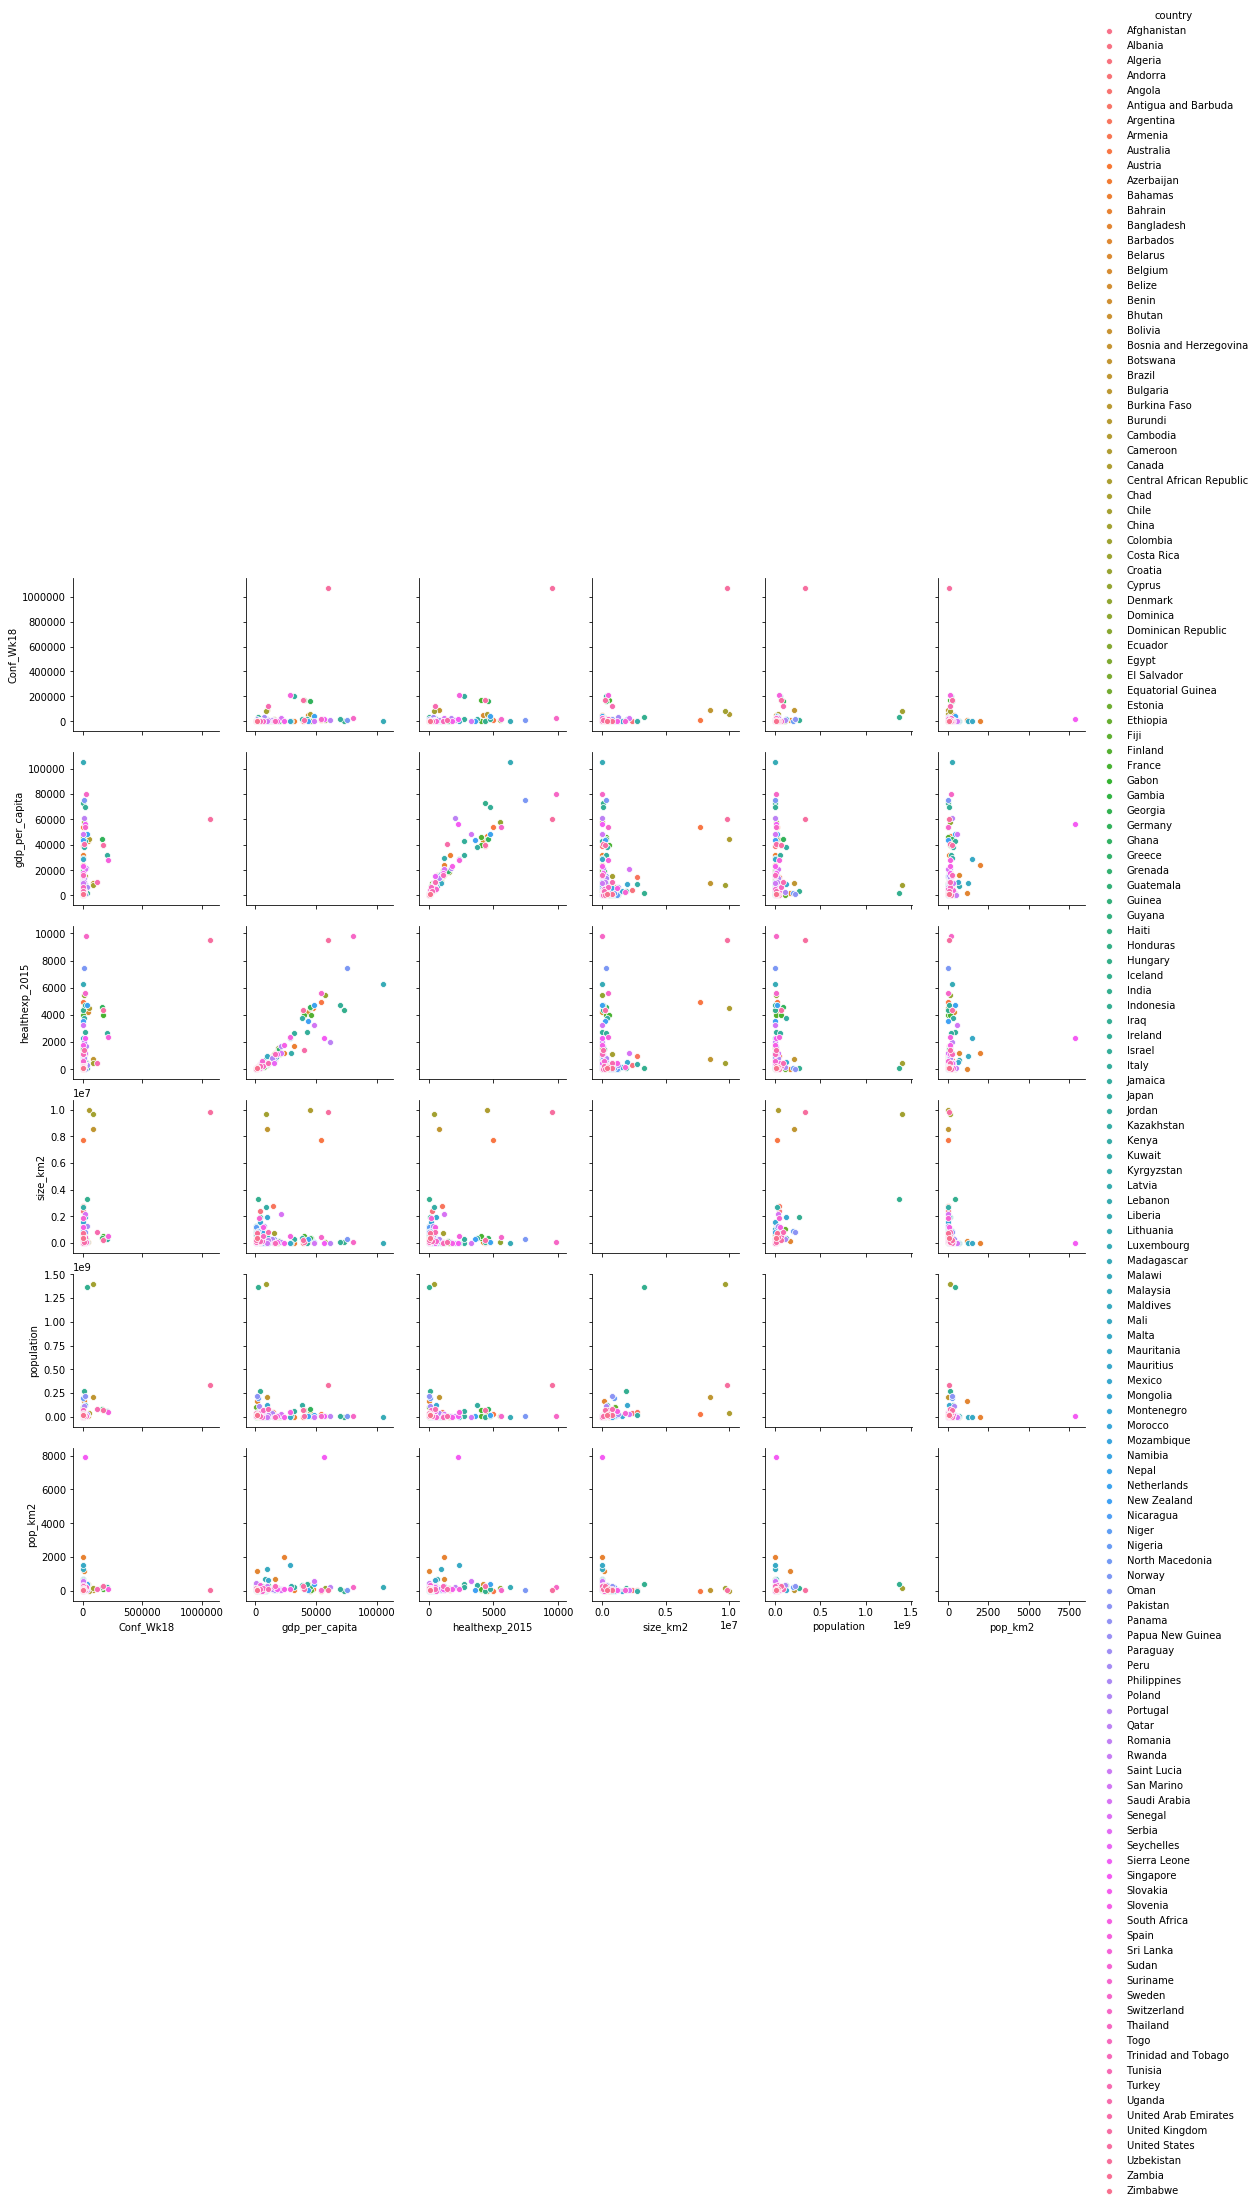

In [108]:
# Little EDA on this DS:
df_sample_01= df_clus_02[['country','Conf_Wk18','gdp_per_capita','healthexp_2015','size_km2','population','pop_km2']]
#CAUTION: This one's heavy...
sbn.pairplot(df_sample_01,hue='country')
#display(df_sample_01)

In [112]:
# OK, so for starters, I'll preprocess the DS
# Nothing to turn into pseudobinaries (one-hot)
# Scaling the vars
tmp_df= df_clus_02.drop(columns=['country'])
df_clus_03= tmp_df.apply(lambda x: x/x.max(),axis=0)
df_clus_03.describe()

,Conf_Wk10,Conf_Wk11,Conf_Wk12,Conf_Wk13,Conf_Wk14,Conf_Wk15,Conf_Wk16,Conf_Wk17,Conf_Wk18,Conf_Wk4,...,Fatal_Wk7,Fatal_Wk8,Fatal_Wk9,gdp_nominal,gdp_per_capita,healthexp_2010,healthexp_2015,size_km2,population,pop_km2
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,...,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,0.008070,0.012261,0.025721,0.032563,0.023861,0.021387,0.020384,0.019626,0.019441,0.006993,...,0.006908,0.006913,0.007005,0.026372,0.147804,0.142580,0.120383,0.070964,0.033159,0.027644
std,0.083309,0.087123,0.114449,0.127285,0.100581,0.094159,0.091583,0.089519,0.088829,0.083039,...,0.083045,0.083044,0.083042,0.102272,0.190634,0.226971,0.188517,0.171793,0.118668,0.088037
min,0.000000,0.000000,0.000000,0.000000,0.000003,0.000004,0.000007,0.000007,0.000007,0.000000,...,0.000000,0.000000,0.000000,0.000025,0.002783,0.002120,0.001732,0.000006,0.000025,0.000241
25%,0.000000,0.000012,0.000074,0.000142,0.000131,0.000124,0.000120,0.000128,0.000123,0.000000,...,0.000000,0.000000,0.000000,0.000632,0.023119,0.010350,0.011102,0.003845,0.002109,0.003800
50%,0.000025,0.000222,0.001105,0.001591,0.001440,0.001149,0.001312,0.001428,0.001370,0.000000,...,0.000000,0.000000,0.000000,0.002440,0.062491,0.043646,0.039112,0.016386,0.007178,0.011274
75%,0.000198,0.001395,0.005317,0.007275,0.005720,0.005910,0.007179,0.006953,0.007237,0.000000,...,0.000000,0.000000,0.000000,0.014220,0.177574,0.132311,0.118150,0.058262,0.021591,0.025462
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [260]:
# Now, feature reduction. I'll go with kernel PCA (radial-base-f)

# TODO: Explore more dimensionality reduction processes
# (simple PCA, SVD, remove highly correlated features, etc)
# And get components based on variance explainability

kpca= KernelPCA(kernel='rbf',gamma=1,n_components=2)
df_kpca= kpca.fit_transform(df_clus_03)
#df_clus_04
# Getting the explained variance
#kpca_expl_var= np.var(df_kpca,axis=0)
#kpca_expl_var_ratio = kpca_expl_var / np.sum(kpca_expl_var)
df_clus_04= pd.DataFrame(df_kpca,columns=['c1','c2'])
df_clus_04.describe()


,c1,c2
count,1.450000e+02,1.450000e+02
mean,-2.431006e-17,-4.235118e-17
std,3.426066e-01,1.937109e-01
min,-2.283511e-01,-7.679681e-01
25%,-2.110435e-01,-5.362993e-02
50%,-1.783556e-01,-8.974690e-03
75%,1.901350e-02,7.916508e-02
max,9.761900e-01,3.739331e-01


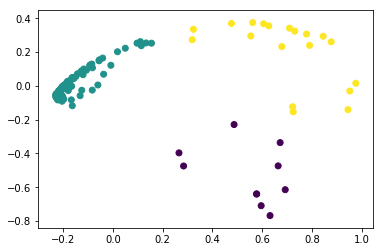

In [324]:
# Clustering:
# I'll seek countries with similar characteristics, using 
# The previous dataset with 2 components
# A Gaussian Mixture Model

df_clus_04.head(6)
r_seed= 1948651334
np.random.seed(r_seed)
# TODO: Set and check several estimators
#gmm_est= {covar_type: GaussianMixture(n_components=n_comp,covariance_type=covar_type,max_iter=25) for covar_type in ['spherical','diag','tied','full']}
#for index,(name,estim) in enumerate(gmm_est.items()):
#    estim.fit(df_clus_04)
# TODO: Tune all the hyperparameters (gamma)

# First, a test run of 3 clusters

n_comp= 3
gmm_clus_01= GaussianMixture(n_comp,covariance_type='full',max_iter=100)
clus_fit_01= gmm_clus_01.fit(df_clus_04)
clus_pred_01= clus_fit_01.fit_predict(df_clus_04)
mplot.scatter(df_clus_04['c1'],df_clus_04['c2'],c=clus_pred_01)

# It seems a good choice because the clusters are well separated.

C:\Users\dalop\Anaconda3\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


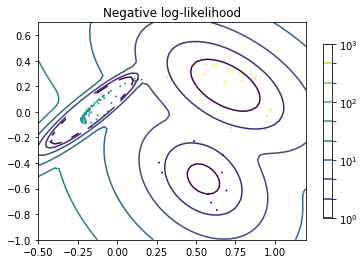

In [325]:
# Contour plot - Density

from matplotlib.colors import LogNorm
x = np.linspace(-.5, 1.2)
y = np.linspace(-1., .7)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clus_fit_01.score_samples(XX)
Z = Z.reshape(X.shape)

CS = mplot.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),levels=np.logspace(0, 3, 10))
CB = mplot.colorbar(CS, shrink=0.8, extend='both')
mplot.scatter(df_clus_04['c1'],df_clus_04['c2'], .8,c=clus_pred_01)

mplot.title('Negative log-likelihood')
mplot.axis('tight')
mplot.show()



In [326]:
# Akaike and Bayes IC
print('AIC: {}, BIC: {}'.format(clus_fit_01.aic(df_clus_04),clus_fit_01.bic(df_clus_04)))

AIC: -514.9481020210005, BIC: -464.3436283998508


In [342]:
# Now, trying to find the best cluster number
# I'll use BIC, as vars=2 < samples=145 (still a little small though)
# Adding AI just for comparison
np.random.seed(r_seed)
clus_limit= 30
arr_nclus=[]
arr_aic=[]
arr_bic=[]
for n_clus in range(3,clus_limit+1):
    tmp_gmm_fit= GaussianMixture(n_clus,covariance_type='full',max_iter=100).fit(df_clus_04)
    tmp_clus_pred= tmp_gmm_fit.fit_predict(df_clus_04)
    tmp_aic,tmp_bic= (tmp_gmm_fit.aic(df_clus_04),tmp_gmm_fit.bic(df_clus_04))
    #print('NClus:{}, AIC: {}, BIC: {}'.format(n_clus,tmp_aic,tmp_bic))
    arr_nclus.append(n_clus)
    arr_aic.append(tmp_aic)
    arr_bic.append(tmp_bic)
#mplot.scatter(df_clus_04['c1'],df_clus_04['c2'],c=tmp_clus_pred)
df_eval=pd.DataFrame({'n_cluster':arr_nclus,'aic':arr_aic,'bic':arr_bic},columns=['n_cluster','aic','bic'])
display(df_eval)
print('Minimum BIC')
display(df_eval[df_eval['bic']==min(df_eval['bic'])])

,n_cluster,aic,bic
0,3,-514.948102,-464.343628
1,4,-711.660794,-643.195918
2,5,-629.249027,-542.923748
3,6,-623.987817,-519.802136
4,7,-768.592411,-646.546327
5,8,-772.754122,-632.847636
6,9,-792.580413,-634.813525
7,10,-822.332591,-646.705300
8,11,-859.588157,-666.100464
9,12,-852.003472,-640.655376


Minimum BIC


,n_cluster,aic,bic
8,11,-859.588157,-666.100464


1
1
2
3
1
2
3
4
5
6
7


C:\Users\dalop\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\dalop\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\dalop\Anaconda3\lib\site-packages\matplotlib\figure.py:98: Matplotlib

8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


ValueError: num must be 1 <= num <= 22, not 23

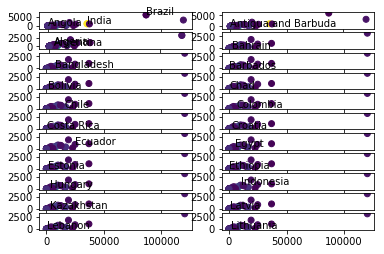

In [360]:
# Plotting Countries by cluster (with 11 clusters)

n_cluster_val= 11

df_gmm_fit_01= GaussianMixture(n_cluster_val,covariance_type='full',max_iter=100).fit(df_clus_04)
df_clus_pred_01= df_gmm_fit_01.fit_predict(df_clus_04)
# Cluster membership for each observation / country
df_membership= pd.DataFrame(df_clus_pred_01,columns=['cluster'])
dfs= [df_clus_02[['country','Conf_Wk18','Fatal_Wk18','pop_km2']],df_membership]
df_clus_05= pd.concat(dfs,axis=1,sort=False)
#display(df_clus_05)

i= 1
clusters= df_clus_05['cluster'].sort_values().unique()
for clus_id in clusters:
    tmp_df= df_clus_05[df_clus_05['cluster']==clus_id]
    df_len= len(tmp_df)
    mplot.subplot(len(clusters),2,i)
    print(i)
    mplot.scatter(tmp_df['Conf_Wk18'],tmp_df['Fatal_Wk18'],c=tmp_df['pop_km2'])
    for i in range(len(tmp_df)):
        val_conf=tmp_df['Conf_Wk18'].iloc[i]
        val_fatal=tmp_df['Fatal_Wk18'].iloc[i]
        val_density=tmp_df['pop_km2'].iloc[i]
        val_cntry=tmp_df['country'].iloc[i]
        #print('{},{},{},{}'.format(val_conf,val_fatal,val_density,val_cntry))
        mplot.text(val_conf,val_fatal,val_cntry)
        i= i + 1
        print(i)
        mplot.subplot(len(clusters),2,i)
        mplot.scatter(tmp_df['Conf_Wk18'],tmp_df['Fatal_Wk18'],c=tmp_df['pop_km2'])
        #mplot.scatter(np.log(tmp_df['Conf_Wk18']),np.log(tmp_df['Fatal_Wk18']),c=tmp_df['pop_km2'])
        i= i+1
